# Optimal learning rates

In this tutorial, we'll use the MedNIST dataset to explore MONAI's `LearningRateFinder` and use it to get an initial estimate of a learning rate.

We then employ one of Pytorch's cyclical learning rate schedulers to vary the learning rate over the course of the optimisation. This has been shown to give improved results: https://arxiv.org/abs/1506.01186. We'll compare this to the optimiser's (ADAM) default learning rate and the learning rate suggested by `LearningRateFinder`.

This 2D classification is fairly easy, so to make it a little harder (and faster), we'll use a small network, only a subset of the images (~250 and ~25 for training and validation, respectively), we'll crop the images (from 64x64 to 20x20) and we won't use any random transformations. In a more difficult scenario, we probably wouldn't want to do any of these things.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/modules/learning_rate.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib

## Setup imports

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet
from monai.networks.utils import eval_mode
from monai.optimizers import LearningRateFinder
from monai.transforms import (
    Activations,
    AsDiscrete,
    AddChanneld,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    ScaleIntensityd,
    ToTensord,
    ToTensor,
)
from monai.utils import set_determinism
from torch.utils.data import DataLoader
from tqdm import trange

print_config()

MONAI version: 0.6.0+1.g8365443a
Numpy version: 1.20.3
Pytorch version: 1.9.0a0+c3d40fd
MONAI flags: HAS_EXT = True, USE_COMPILED = False
MONAI rev id: 8365443ababac313340467e5987c7babe2b5b86a

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.15.0
Pillow version: 8.2.0
Tensorboard version: 2.2.0
gdown version: 3.13.0
TorchVision version: 0.10.0a0
ITK version: 5.1.2
tqdm version: 4.53.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.1.4
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

## Set deterministic training for reproducibility

In [4]:
set_determinism(seed=0)

## Define MONAI transforms and get dataset and data loader

In [5]:
transforms = Compose(
    [
        LoadImaged(keys="image"),
        AddChanneld(keys="image"),
        ScaleIntensityd(keys="image"),
        CenterSpatialCropd(keys="image", roi_size=(20, 20)),
        ToTensord(keys="image"),
    ]
)

In [6]:
# Set fraction of images used for testing to be very high, then don't use it. In this way, we can reduce the number
# of images in both train and val. Makes it faster and makes the training a little harder.
def get_data(section):
    ds = MedNISTDataset(
        root_dir=root_dir,
        transform=transforms,
        section=section,
        download=True,
        num_workers=10,
        val_frac=0.0005,
        test_frac=0.995,
    )
    loader = DataLoader(ds, batch_size=30, shuffle=True, num_workers=10)
    return ds, loader


train_ds, train_loader = get_data("training")
val_ds, val_loader = get_data("validation")

print(len(train_ds))
print(len(val_ds))
print(train_ds[0]["image"].shape)
num_classes = train_ds.get_num_classes()

y_pred_trans = Compose([ToTensor(), Activations(softmax=True)])
y_trans = Compose([ToTensor(), AsDiscrete(to_onehot=True, n_classes=num_classes)])

Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
file /home/rbrown/data/MONAI/MedNIST.tar.gz exists, skip downloading.
extracted file /home/rbrown/data/MONAI/MedNIST exists, skip extracting.


Loading dataset: 100%|██████████| 25/25 [00:00<00:00, 1242.09it/s]

Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
file /home/rbrown/data/MONAI/MedNIST.tar.gz exists, skip downloading.
extracted file /home/rbrown/data/MONAI/MedNIST exists, skip extracting.
249
25
torch.Size([1, 20, 20])


## Randomly pick images from the dataset to visualize and check

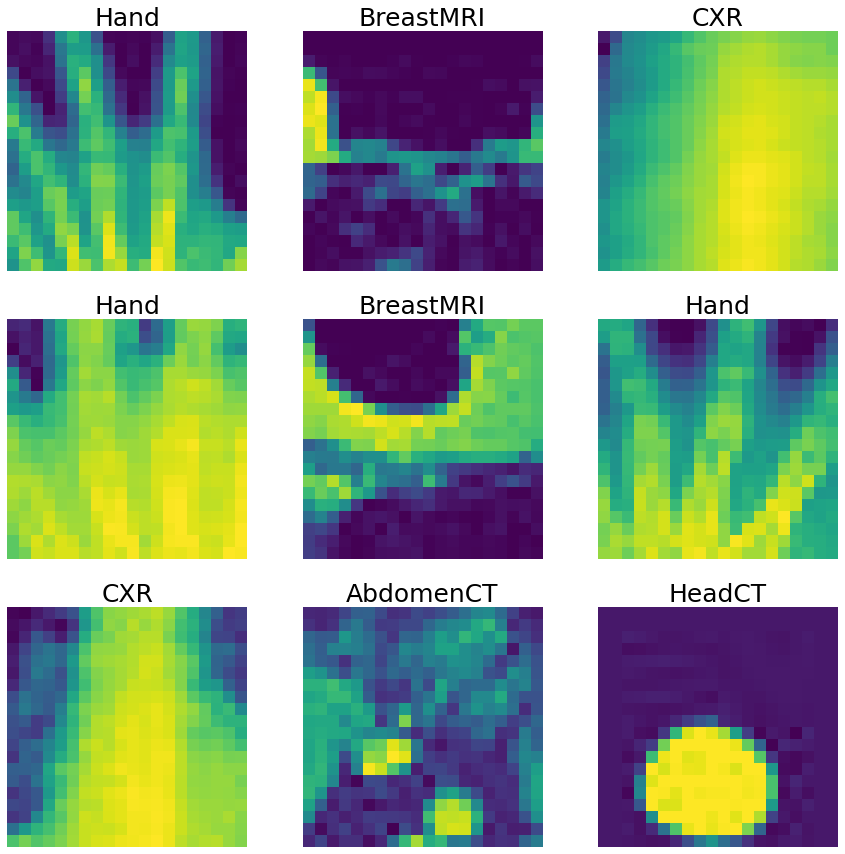

In [7]:
%matplotlib inline
fig, axes = plt.subplots(3, 3, figsize=(15, 15), facecolor="white")
for i, k in enumerate(np.random.randint(len(train_ds), size=9)):
    data = train_ds[k]
    im, title = data["image"], data["class_name"]
    ax = axes[i // 3, i % 3]
    im_show = ax.imshow(im[0])
    ax.set_title(title, fontsize=25)
    ax.axis("off")

## Define loss function and network

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_function = torch.nn.CrossEntropyLoss()
auc_metric = ROCAUCMetric()


def get_new_net():
    return DenseNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=num_classes,
        init_features=2,
        growth_rate=2,
        block_config=(2,),
    ).to(device)


model = get_new_net()

# Estimate optimal learning rate

Use MONAI's `LearningRateFinder` to get an initial estimate of a learning rate. Assume that it's in the range 1e-5, 1e0. If that weren't the case (which we'd notice in the plot), we could just try again over a larger/different window.

We can plot the results and extract the learning rate with the steepest gradient.

Computing optimal learning rate:  90%|█████████ | 18/20 [00:14<00:01,  1.26it/s]


Stopping early, the loss has diverged
Resetting model and optimizer


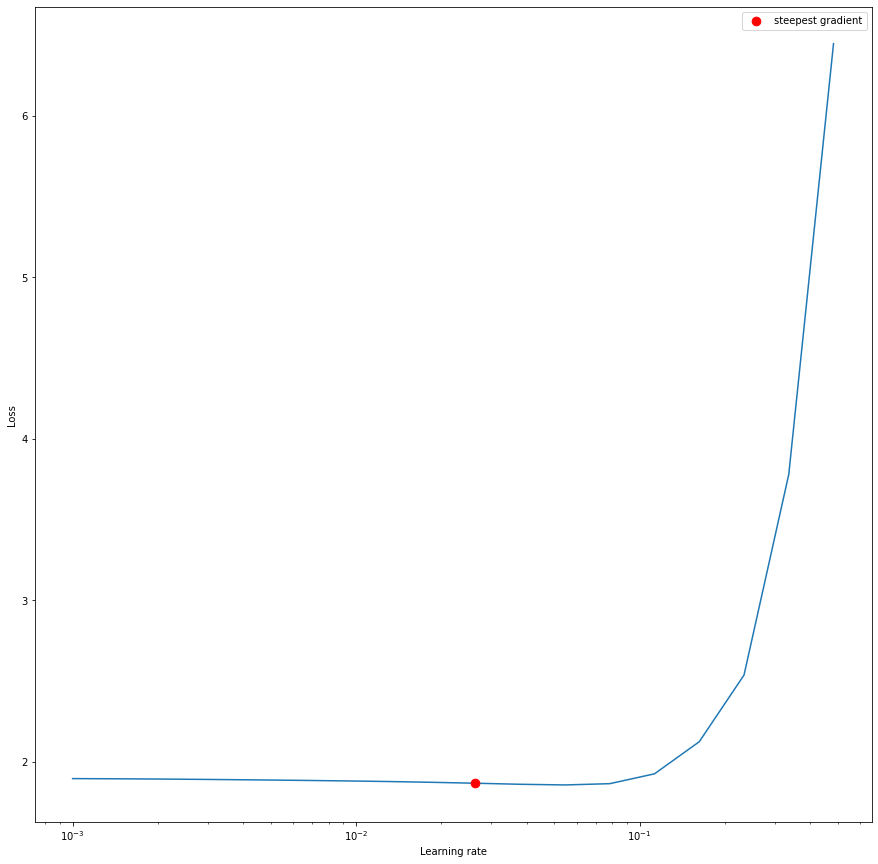

In [9]:
%matplotlib inline
lower_lr, upper_lr = 1e-3, 1e-0
optimizer = torch.optim.Adam(model.parameters(), lower_lr)
lr_finder = LearningRateFinder(model, optimizer, loss_function, device=device)
lr_finder.range_test(train_loader, val_loader, end_lr=upper_lr, num_iter=20)
steepest_lr, _ = lr_finder.get_steepest_gradient()
ax = plt.subplots(1, 1, figsize=(15, 15), facecolor="white")[1]
_ = lr_finder.plot(ax=ax)

## Live plotting

This function is just a wrapper around `range`/`trange` such that the plots are updated on every iteration.

In [10]:
def plot_range(data, wrapped_generator):
    plt.ion()
    for q in data.values():
        for d in q.values():
            if isinstance(d, dict):
                ax = d["line"].axes
                ax.legend()
                fig = ax.get_figure()
    fig.show()

    for i in wrapped_generator:
        yield i
        for q in data.values():
            for d in q.values():
                if isinstance(d, dict):
                    d["line"].set_data(d["x"], d["y"])
                    ax = d["line"].axes
                    ax.legend()
                    ax.relim()
                    ax.autoscale_view()
        fig.canvas.draw()

## Training

The training looks slightly different from a vanilla loop, but this is only because it loops across each of the different learning rate methods (standard, steepest and cyclical), such that they can be updated simultaneously

In [11]:
def get_model_optimizer_scheduler(d):
    d["model"] = get_new_net()

    if "lr_lims" in d:
        d["optimizer"] = torch.optim.Adam(
            d["model"].parameters(), d["lr_lims"][0]
        )
        d["scheduler"] = torch.optim.lr_scheduler.CyclicLR(
            d["optimizer"],
            base_lr=d["lr_lims"][0],
            max_lr=d["lr_lims"][1],
            step_size_up=d["step"],
            cycle_momentum=False,
        )
    elif "lr_lim" in d:
        d["optimizer"] = torch.optim.Adam(d["model"].parameters(), d["lr_lim"])
    else:
        d["optimizer"] = torch.optim.Adam(d["model"].parameters())


def train(max_epochs, axes, data):
    for d in data.keys():
        get_model_optimizer_scheduler(data[d])

        for q, i in enumerate(["train", "auc", "acc"]):
            data[d][i] = {"x": [], "y": []}
            (data[d][i]["line"],) = axes[q].plot(
                data[d][i]["x"], data[d][i]["y"], label=d
            )

        val_interval = 1

    for epoch in plot_range(data, trange(max_epochs)):

        for d in data.keys():
            data[d]["epoch_loss"] = 0
        for batch_data in train_loader:
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)

            for d in data.keys():
                data[d]["optimizer"].zero_grad()
                outputs = data[d]["model"](inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                data[d]["optimizer"].step()
                if "scheduler" in data[d]:
                    data[d]["scheduler"].step()
                data[d]["epoch_loss"] += loss.item()
        for d in data.keys():
            data[d]["epoch_loss"] /= len(train_loader)
            data[d]["train"]["x"].append(epoch + 1)
            data[d]["train"]["y"].append(data[d]["epoch_loss"])

        if (epoch + 1) % val_interval == 0:
            with eval_mode(*[data[d]["model"] for d in data.keys()]):
                for d in data:
                    data[d]["y_pred"] = torch.tensor(
                        [], dtype=torch.float32, device=device
                    )
                y = torch.tensor([], dtype=torch.long, device=device)
                for val_data in val_loader:
                    val_images = val_data["image"].to(device)
                    val_labels = val_data["label"].to(device)
                    for d in data:
                        data[d]["y_pred"] = torch.cat(
                            [data[d]["y_pred"], data[d]["model"](val_images)],
                            dim=0,
                        )
                    y = torch.cat([y, val_labels], dim=0)

                for d in data:
                    y_onehot = [y_trans(i) for i in decollate_batch(y)]
                    y_pred_act = [y_pred_trans(i) for i in decollate_batch(data[d]["y_pred"])]
                    auc_metric(y_pred_act, y_onehot)
                    auc_result = auc_metric.aggregate()
                    auc_metric.reset()
                    del y_pred_act, y_onehot
                    data[d]["auc"]["x"].append(epoch + 1)
                    data[d]["auc"]["y"].append(auc_result)

                    acc_value = torch.eq(data[d]["y_pred"].argmax(dim=1), y)
                    acc_metric = acc_value.sum().item() / len(acc_value)
                    data[d]["acc"]["x"].append(epoch + 1)
                    data[d]["acc"]["y"].append(acc_metric)

<IPython.core.display.Javascript object>


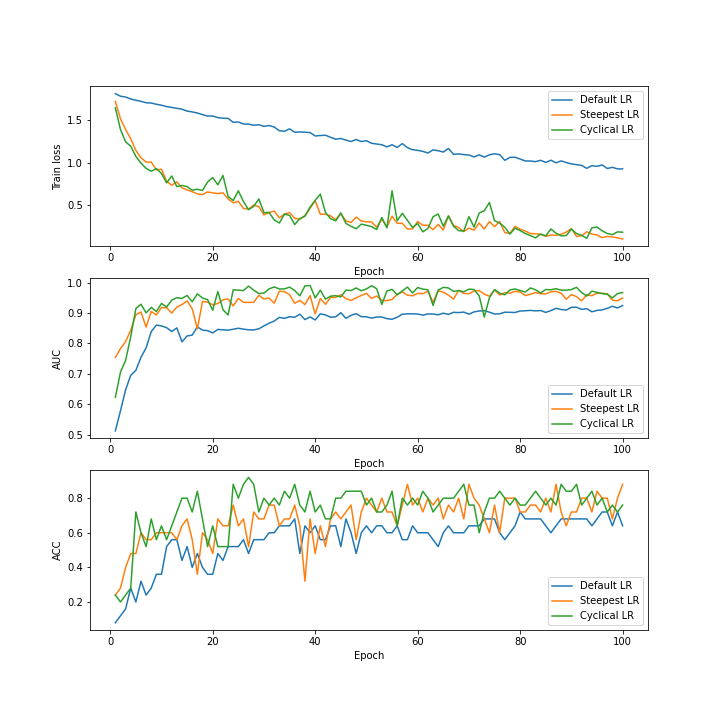

100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


In [12]:
%matplotlib notebook
fig, axes = plt.subplots(3, 1, figsize=(10, 10), facecolor="white")
for ax in axes:
    ax.set_xlabel("Epoch")
axes[0].set_ylabel("Train loss")
axes[1].set_ylabel("AUC")
axes[2].set_ylabel("ACC")

# In the paper referenced at the top of this notebook, a step
# size of 8 times the number of iterations per epoch is suggested.
step_size = 8 * len(train_loader)

max_epochs = 100
data = {}
data["Default LR"] = {}
data["Steepest LR"] = {"lr_lim": steepest_lr}
data["Cyclical LR"] = {
    "lr_lims": (0.8 * steepest_lr, 1.2 * steepest_lr),
    "step": step_size,
}

train(max_epochs, axes, data)

## Conclusion

Unsurprisingly, both `Steepest LR` and `Cyclical LR` show quicker convergence of the loss function than `Default LR`.

There's not much of a difference in this example between `Steepest LR` and `Cyclical LR`. A bigger difference may be apparent in a more complex optimisation problem, but feel free to play with the step size, and the lower and upper cyclical limits.

## Cleanup data directory

Remove directory if a temporary was used.

In [13]:
if directory is None:
    shutil.rmtree(root_dir)